# Canucks - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 17, 2022

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32922, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32922 entries, 0 to 32921
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            32922 non-null  int64  
 1   dimCustomerMasterId     32922 non-null  int64  
 2   customerNumber          32922 non-null  object 
 3   year                    32922 non-null  int64  
 4   productGrouping         32922 non-null  object 
 5   totalSpent              32922 non-null  float64
 6   recentDate              32922 non-null  object 
 7   attendancePercent       32922 non-null  float64
 8   renewedBeforeDays       32922 non-null  int64  
 9   isBuyer                 32922 non-null  object 
 10  source_tenure           32922 non-null  int64  
 11  tenure                  32922 non-null  int64  
 12  distToVenue             32922 non-null  float64
 13  totalGames              32922 non-null  int64  
 14  recency                 32922 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "is_Lockdown",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 11)
Unseen Data For Predictions: (4172, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
         "attendancePercent",
          "distToVenue",
          "recency",
          "source_tenure",
          "renewedBeforeDays",
          "is_Lockdown",
          "totalSpent"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8072,0.8849,0.8352,0.8014,0.8179,0.6133,0.6140,1.0210
lr,Logistic Regression,0.6475,0.7073,0.6803,0.6555,0.6666,0.2929,0.2942,0.3930


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8070,0.8922,0.8234,0.8079,0.8156,0.6131,0.6132
1,0.8129,0.8866,0.8589,0.7963,0.8264,0.6242,0.6263
2,0.8020,0.8864,0.8225,0.8009,0.8116,0.6030,0.6033
3,0.8104,0.8898,0.8378,0.8046,0.8209,0.6198,0.6204
4,0.7866,0.8667,0.8234,0.7779,0.8000,0.5716,0.5727
5,0.8109,0.8852,0.8512,0.7977,0.8236,0.6204,0.6219
6,0.8208,0.8941,0.8473,0.8144,0.8305,0.6406,0.6412
7,0.8158,0.8833,0.8377,0.8127,0.8250,0.6307,0.6311
8,0.8074,0.8816,0.8290,0.8050,0.8168,0.6138,0.6141
9,0.7984,0.8830,0.8205,0.7968,0.8085,0.5958,0.5961


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5107, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
27815,7,3059,8182172,2021,Quarter,2982.8,2021-12-12,1.000000,45,TRUE,...,0,0,0.0,1,46,10,0,1,0.3838,0.6162
27816,7,4926,1576687,2021,Quarter,1874.4,2021-12-06,1.000000,23,TRUE,...,0,0,0.0,1,46,10,0,0,0.5611,0.4389
27817,7,5586,5332293,2021,Quarter,4475.3,2021-12-06,1.000000,22,TRUE,...,0,0,0.0,1,46,10,0,1,0.4291,0.5709
27818,7,6769,12925792,2021,Full Season,14751.7,2021-12-14,1.055556,47,TRUE,...,0,0,0.0,1,46,10,0,0,0.8014,0.1986
27819,7,7059,7876672,2021,Full Season,13460.6,2021-12-12,0.902778,102,TRUE,...,0,0,0.0,1,46,10,0,0,0.9301,0.0699


In [11]:
new_predictions["Label"].value_counts()

0    4005
1    1102
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    2362
(0.2, 0.4]       1131
(0.4, 0.6]        947
(0.6, 0.8]        560
(0.8, 1.0]        107
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

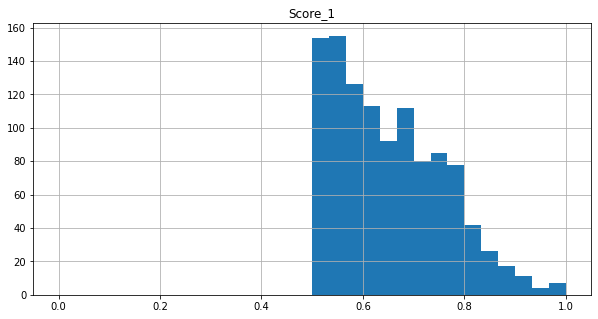

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

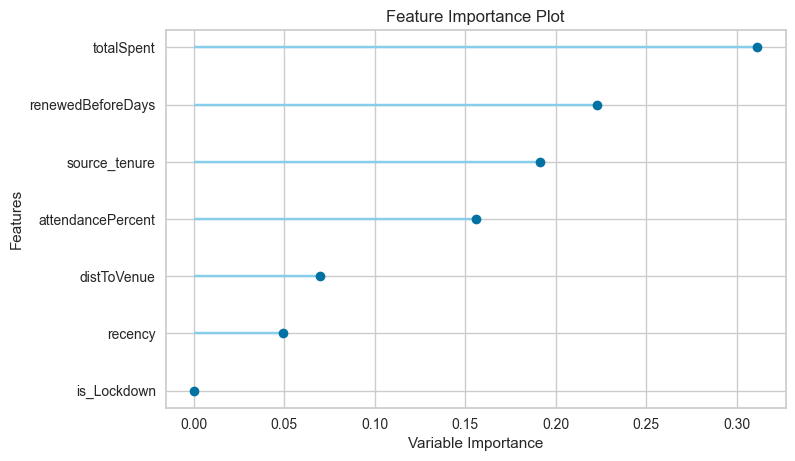

In [14]:
plot_model(best_model, plot='feature')

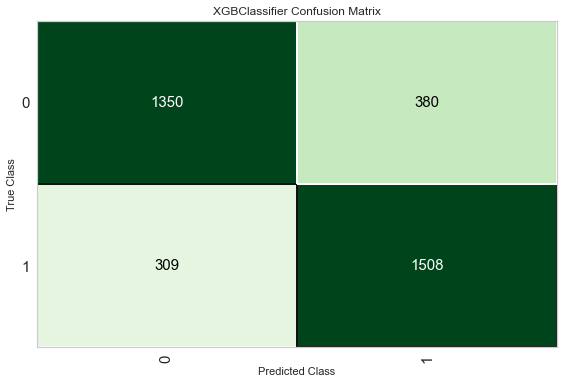

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?